## TRAINING
This notebook has as an objective to use a folder containing the formated .npy files to train a deep learning model that can be used in lieu of an FEA model to any accuracy above random, for a proof of concept that it is possible to do so, such that further research can be done afterward to optimize architecture, hyperparameters and data being fed in.

In [1]:
##  imports

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pathlib
import PREPROCESSING_splitting as split
import matplotlib.pyplot as plt

splitting functions imported


## WEIGHTS AND BIASES
This section's purpose  is to set up logging for the tests

In [63]:
import wandb

In [3]:
#import importlib
#importlib.reload(torch)

In [2]:
## first, create a class to load the files that are to be fed to the neural network, 
## for both the inputs and the outputs. To avoid confusion I'll refer to the inputs to the 
## FEA model as 'bound_conds' (boundary conditions), and the outputs as 'targets', while what 
## is fed into the neural network will be called an "input", and the output of the neural network "prediction"
## this function should probably be transformed into a dataloader later for a larger dataset, 
## but for now we'll keep it like this

def get_dataset(dataset_path, glob_parameter = '*.npy'):
    # concatenates all samples into a list of boundary conditions and a list of targets
    
    # set paths
    bound_cond_path = pathlib.Path(dataset_path, 'input')
    targets_path = pathlib.Path(dataset_path, 'output')

    test = pathlib.Path('D:/')
    
    
    
    
    # check if folder path is correct
    if bound_cond_path.is_dir() and targets_path.is_dir():
        print('path contains \'input\' and \'output\'')
        pass
    else:
        raise Exception (f'Argument dataset_path: {dataset_path} should contain folders ..\input and ..\output. Please check path')
    
    #create iterators for files
    bound_cond_iterator = bound_cond_path.glob(glob_parameter)
    targets_iterator = targets_path.glob(glob_parameter)
    
    #zip them to ensure that they are going through the same samples 
    samples_iterator = zip(bound_cond_iterator, targets_iterator)
    
    boundary_conditions = np.array([])
    targets = np.array([])
    
    for boundary_condition_files, targets_files in samples_iterator:
        if split.get_number(boundary_condition_files.name) == split.get_number(targets_files.name):
            
            boundary_conditions_temp = np.load(boundary_condition_files)
            targets_temp = np.load(targets_files)
            
            #start array if it hasn't been started yet
            if boundary_conditions.size == 0 and targets.size == 0:
                boundary_conditions = boundary_conditions_temp
                targets = targets_temp
            else:
                boundary_conditions = np.concatenate((boundary_conditions, boundary_conditions_temp), axis = 0)
                targets = np.concatenate((targets, targets_temp), axis = 0)
        else:
            raise Exception('the samples in the iterator are not synced')
    
    return torch.from_numpy(boundary_conditions).float(), torch.from_numpy(targets).float()
    

In [4]:
folders_path =  pathlib.Path('D:/Ansys Simulations/Project/2D/data/proof_of_concept/scaled/arrays')
dataset = get_dataset(dataset_path = folders_path)
print(dataset[0].shape)
print(dataset[1].shape)

path contains 'input' and 'output'
torch.Size([102, 7, 32, 32])
torch.Size([102, 4, 32, 32])


## BASE

In [93]:
## define the neural network's general shape

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        ## convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 7, out_channels = 14, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 14, out_channels = 16, kernel_size = 3, padding = 1)
        self.deconv1 = nn.ConvTranspose2d(in_channels = 16, out_channels = 14, kernel_size = 3, padding = 1)
        self.deconv2 = nn.ConvTranspose2d(in_channels = 14, out_channels = 10, kernel_size = 3, padding = 1)
        self.deconv3 = nn.ConvTranspose2d(in_channels = 10, out_channels = 7, kernel_size = 3, padding = 1)
        self.deconv4 = nn.ConvTranspose2d(in_channels = 7, out_channels = 3, kernel_size = 3, padding = 1)
        
        ## activation
        self.hardtanh = nn.Hardtanh()
        
        
        ##possible for later: MultiheadAttention
        
    def forward(self, boundary_conditions):
        #print(boundary_conditions.shape)
        x = self.conv1(boundary_conditions)
        x = self.hardtanh(x)
        #print(x.shape)
        x = self.conv2(x)
        x = self.hardtanh(x)
        #print(x.shape)
        x = self.deconv1(x)
        x = self.hardtanh(x)
       #print(x.shape)
        x = self.deconv2(x)
        x = self.hardtanh(x)
        #print(x.shape)
        x = self.deconv3(x)
        x = self.hardtanh(x)
       # print(x.shape)
        x = self.deconv4(x)
        x = self.hardtanh(x)
        #print(x.shape)
        return x
    
net = ConvNet().cuda().float()

## test to see if getting the correct size
net.forward(dataset[0][0:1,:,:,:].cuda())

tensor([[[[-0.1848, -0.1949, -0.2107,  ..., -0.2141, -0.2092, -0.2141],
          [-0.1324, -0.1882, -0.2108,  ..., -0.2065, -0.2063, -0.2438],
          [-0.1320, -0.1593, -0.1823,  ..., -0.1713, -0.1719, -0.2261],
          ...,
          [-0.1375, -0.1567, -0.1692,  ..., -0.1834, -0.1763, -0.2223],
          [-0.1251, -0.1263, -0.1496,  ..., -0.1626, -0.1729, -0.2059],
          [-0.1521, -0.1681, -0.1941,  ..., -0.1833, -0.1822, -0.2015]],

         [[-0.0021,  0.0233,  0.0171,  ...,  0.0139,  0.0210,  0.0515],
          [-0.0110,  0.0339,  0.0221,  ...,  0.0152,  0.0098,  0.0695],
          [-0.0095,  0.0590,  0.0451,  ...,  0.0397,  0.0394,  0.0835],
          ...,
          [-0.0168,  0.0678,  0.0430,  ...,  0.0276,  0.0257,  0.0789],
          [ 0.0065,  0.0776,  0.0622,  ...,  0.0415,  0.0328,  0.0763],
          [ 0.0273,  0.0918,  0.0809,  ...,  0.0816,  0.0790,  0.0800]],

         [[-0.1435, -0.1662, -0.1835,  ..., -0.1640, -0.1638, -0.1844],
          [-0.1226, -0.1210, -

In [94]:
## define criterion
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(params = net.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [95]:
## setup logging
wandb.init(config={"epochs": 50, "batch_size": 90, 'architecture':'base_architecture'})

W&B Run: https://app.wandb.ai/walther/Project/runs/23avobon

In [78]:
wandb.config.update({"epochs": 50, "batch_size": 90, 'dataset':'base_architecture'}) 

In [96]:
%%wandb


## define a general training loop
losses = np.array([0,0,0])
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    boundary_conditions, targets = dataset[0][:90,:,:,:].cuda(), dataset[1][:90,:,:,:].cuda()
    #print(type(boundary_conditions))
    #net = net.cuda()
    for i, bc in enumerate(boundary_conditions):
        tgt = targets[i, 1:4, :, :].unsqueeze(0)
        bc = bc.unsqueeze(0)
        #print(i, bc.shape, tgt.shape)

        # get the inputs; data is a list of [boundary_conditions, targets]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        prediction = net(bc)
        loss = criterion(prediction, tgt)
        #print(loss)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 10 mini-batches
            running_val_loss = 0.0
            with torch.no_grad():
                boundary_conditions_val, targets_val = dataset[0][90:,:,:,:].cuda(), dataset[1][90:,:,:,:].cuda()
                for ii, bc_val in enumerate(boundary_conditions_val):
                    tgt_val = targets_val[i, 1:4, :, :].unsqueeze(0)
                    bc_val = bc_val.unsqueeze(0)
                    prediction_val = net(bc_val)
                    val_loss = criterion(prediction_val, tgt_val)
                    
                    running_val_loss+=val_loss.item()
                
            print(f'{epoch + 1} {i + 1} {running_loss} {running_val_loss/10}')
            wandb.log({"loss": running_loss})
            wandb.log({"val_loss": running_val_loss})
            losses = np.vstack((losses, [epoch, running_loss, running_val_loss]))
            #print(losses)
            running_loss = 0.0
            

print('Finished Training')

1 1 0.016714144498109818 0.019145140890032053
2 1 0.0011802840745076537 0.0014103455818258227
3 1 0.0009948427323251963 0.001163372053997591
4 1 0.0008658082224428654 0.0010032846708782016
5 1 0.0007614213973283768 0.0008792710024863482
6 1 0.0006741338293068111 0.000778469064971432
7 1 0.000600143801420927 0.0006948199181351811
8 1 0.0005372070008888841 0.0006248694495297969
9 1 0.00048348819836974144 0.0005661065428284928
10 1 0.00043713697232306004 0.000516299981973134
11 1 0.0003964062489103526 0.00047348100633826107
12 1 0.0003599087649490684 0.0004361393366707489
13 1 0.0003267583088018 0.00040332775097340345
14 1 0.0002965453313663602 0.0003745863679796457
15 1 0.0002692050766199827 0.0003497604833682999
16 1 0.000244844559347257 0.0003288008534582332
17 1 0.00022357015404850245 0.0003116030507953838
18 1 0.00020535557996481657 0.0002979214375955053
19 1 0.00018998519226443022 0.0002873686811653897
20 1 0.00017708781524561346 0.0002794800253468566
21 1 0.0001662269642110914 0.00

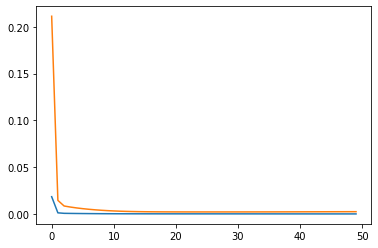

In [7]:
## attempt to plot losses over time
plt.plot(losses[1:,0], losses[1:,1:])

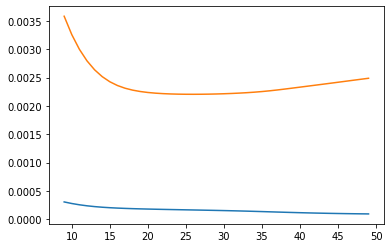

In [8]:
## attempt to plot losses over time to sho where the model started overfitting on the data
plt.plot(losses[10:,0], losses[10:,1:])

Therefore, it can be seen that the network learns some of the relationships in the dataset, and is able to overfit it after a while.

In [19]:
%matplotlib inline 
#f = plt.figure()


#plt.imshow(concat_input[:,:,0])
def plot_grid_2d(concat_input, concat_output):
    
    f, axarr = plt.subplots(2,5, figsize = (15,6)) 
    
    axarr[0,0].imshow(np.abs(concat_input[:,:,0]))
    axarr[0,0].set(title='smoothed map')

    axarr[0,1].imshow(np.abs(concat_input[:,:,1]))
    axarr[0,1].set(title='X displacement B.C.')

    axarr[0,2].imshow(np.abs(concat_input[:,:,2]))
    axarr[0,2].set(title='Y displacement B.C.')

    axarr[0,3].imshow(np.abs(concat_input[:,:,3]))
    axarr[0,3].set(title='Z displacement  B.C')

    axarr[0,4].imshow(np.abs(concat_input[:,:,4]))
    axarr[0,4].set(title='X force B.C.')

    axarr[1,0].imshow(np.abs(concat_input[:,:,5]))
    axarr[1,0].set(title='Y force B.C.')

    axarr[1,1].imshow(np.abs(concat_input[:,:,6]))
    axarr[1,1].set(title='Z force B.C.')

    axarr[1,2].imshow(np.abs(concat_output[:,:,1]))
    axarr[1,2].set(title='X displacement result')

    axarr[1,3].imshow(np.abs(concat_output[:,:,2]))
    axarr[1,3].set(title='Y displacement result')

    axarr[1,4].imshow(np.abs(concat_output[:,:,3]))
    axarr[1,4].set(title='Z displacement result')

    plt.show()

(32, 32, 7) (32, 32, 4)


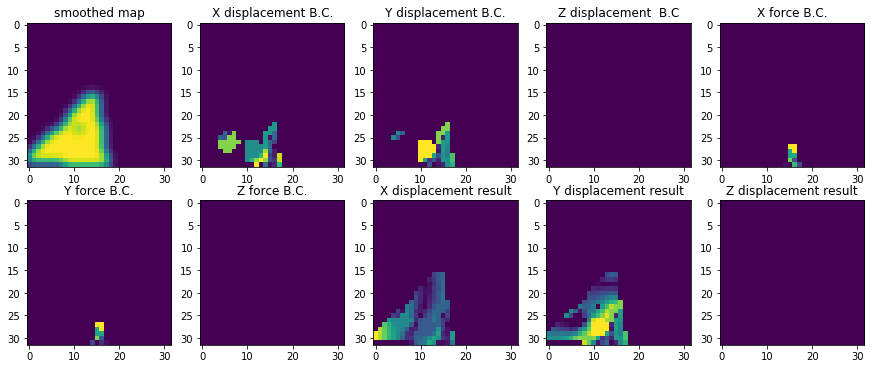

In [20]:
#plot ground truth
sample = 96
sample_bc = np.moveaxis(dataset[0][sample,:,:,:].numpy(), 0, 2)
sample_target = np.moveaxis(dataset[1][sample,:,:,:].numpy(), 0, 2)
print(sample_bc.shape, sample_target.shape)
plot_grid_2d(sample_bc, sample_target)

torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


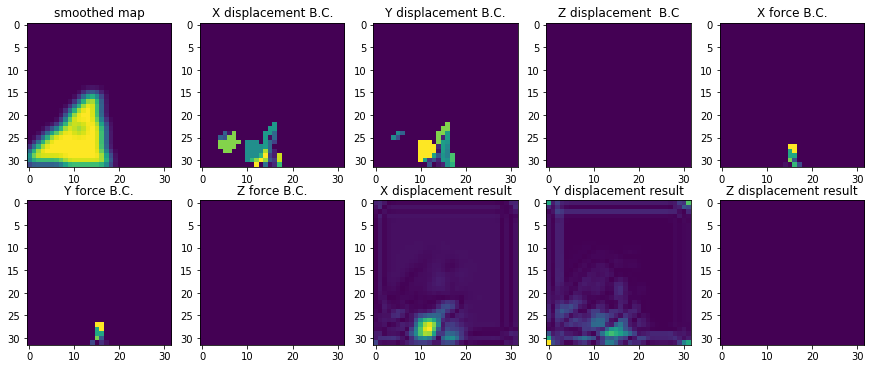

In [41]:
## plot one of the results after passing the convolutional network through it once
sample_prediction = net.forward(dataset[0][sample:sample+1,:,:,:])
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])

So one of the conclusions is that the convolutional network was  able to succesfully learn a model that can be applied to a space to generate a result  that correlates to the target. Even with a very small number of samples, the network was able to learn some basic principles about the geometry of the sample and of the relationships between boundary conditions and targets

In [53]:
## get loss of the results
with torch.no_grad():
    print(dataset[1][sample, 1:4, :, :].unsqueeze(0).shape)
    print(net.forward(dataset[0][sample:sample+1,:,:,:]).shape)
    loss_1_it = criterion(dataset[1][sample, 1:4, :, :].unsqueeze(0), net.forward(dataset[0][sample:sample+1,:,:,:]))
    print(f'{loss_1_it: .9f}')

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
 0.000156545


In [32]:
## create a generator to evaluate how loss progresses with multiple applications of the network
def convolute_iteration(conditions, netwrk, repeat = True):
    with torch.no_grad():
        pred = netwrk(conditions) #torch.Size([1, 3, 32, 32])
        new_condition = conditions.clone()
        new_condition[:, 1:4, :, :] = pred
        i=0
        while repeat:
            i +=1
            print(i)
            pred = netwrk(new_condition)
            new_condition = conditions.clone()
            new_condition[:, 1:4, :, :] = pred
            
            yield pred

In [118]:
## create iterator intance for loss plot
predicts = convolute_iteration(dataset[0][sample:sample+1,:,:,:], net)
loss_iterator = []

95
 0.116603315


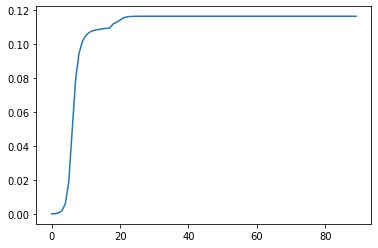

In [213]:
with torch.no_grad():
    
    loss_2_it = criterion(dataset[1][sample, 1:4, :, :].unsqueeze(0), next(predicts))
    loss_iterator.append(loss_2_it)
    print(f'{loss_2_it: .9f}')
    plt.plot(loss_iterator)

What has been shown with this is that subsequent applications of this model don't increase its accuracy, however it does converge to a certain value. The fact that there is convergence is grounds for exploring whether this convergence can be used as a feature of the model itself.

In [215]:
## create iterator intance for prediction plot
predicts = convolute_iteration(dataset[0][sample:sample+1,:,:,:], net)


2
torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


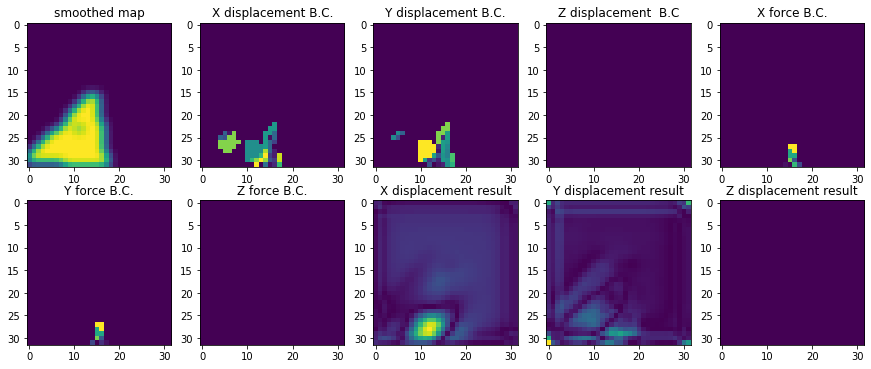

In [217]:
sample_prediction = next(predicts)
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])

Now I want to explore a lot of things and their impact on the model's predictions:

- leaning rates
- different conv deconv architectures
- pre-trained models (if models trained on images help with accuracy in this case, then it is possible to use models trained in other types of object for the 3d version)
- attention
- different losses
- increase amount of model forward feeds before doing gradient descent to try to get the model to converge closer to the target value if applied several times
- Other activation strategies

## ENCODER DECODER

In [102]:
##update loging
wandb.init(config={"epochs": 30, "batch_size": 90,'learning_rate': 0.0005, 'architecture':'encoder_decoder_architecture'})

W&B Run: https://app.wandb.ai/walther/Project/runs/1a7sqgcg

In [100]:

## First, see the result of a conv-deconv architecture with exactly the same parameters but that condenses
## the inputs into a feature array first
## define the neural network's general shape

class Encode_decode_Net(nn.Module):
    def __init__(self):
        super(Encode_decode_Net, self).__init__()
        
        ## convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 7, out_channels = 14, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 14, out_channels = 16, kernel_size = 3, padding = 1)
        self.deconv1 = nn.ConvTranspose2d(in_channels = 16, out_channels = 14, kernel_size = 3, padding = 1)
        self.deconv2 = nn.ConvTranspose2d(in_channels = 14, out_channels = 10, kernel_size = 2,stride = 2, padding = 0)
        self.deconv3 = nn.ConvTranspose2d(in_channels = 10, out_channels = 7, kernel_size = 2, stride = 2, padding = 0)
        self.deconv4 = nn.ConvTranspose2d(in_channels = 7, out_channels = 3, kernel_size = 3, padding = 1)
        
        ## activation
        self.hardtanh = nn.Hardtanh()
        self.tanh = nn.Tanh()
        self.prelu = nn.PReLU()
        self.leaky_relu = nn.LeakyReLU()
        
        ## Pooling
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        
    def forward(self, boundary_conditions):
        '''
        torch.Size([1, 7, 32, 32])
        torch.Size([1, 14, 16, 16])
        torch.Size([1, 16, 8, 8])
        torch.Size([1, 14, 8, 8])
        torch.Size([1, 10, 16, 16])
        torch.Size([1, 7, 32, 32])
        torch.Size([1, 3, 32, 32])
        '''
        
        #print(boundary_conditions.shape)
        x = self.conv1(boundary_conditions)
        x = self.maxpool(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv1(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv2(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv3(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv4(x)
        x = self.tanh(x)
        #print(x.shape)
        return x
    
        
net = Encode_decode_Net().cuda().float()

## test to see if getting the correct size
net.forward(dataset[0][0:1,:,:,:].cuda());

In [101]:
## define criterion
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(params = net.parameters(), lr=0.0005, betas=(0.9, 0.999))

In [104]:
%%wandb 
## logging cell magic
##
wandb.watch(net)



## define a general training loop
losses = np.array([0,0,0])
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    boundary_conditions, targets = dataset[0][:90,:,:,:].cuda(), dataset[1][:90,:,:,:].cuda()
    #print(type(boundary_conditions))
    for i, bc in enumerate(boundary_conditions):
        tgt = targets[i, 1:4, :, :].unsqueeze(0)
        bc = bc.unsqueeze(0).cuda()
        #print(i, bc.shape, tgt.shape)

        # get the inputs; data is a list of [boundary_conditions, targets]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        prediction = net(bc)
        loss = criterion(prediction, tgt)
        #print(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 10 mini-batches
            running_val_loss = 0.0
            with torch.no_grad():
                boundary_conditions_val, targets_val = dataset[0][90:,:,:,:].cuda(), dataset[1][90:,:,:,:].cuda()
                for ii, bc_val in enumerate(boundary_conditions_val):
                    tgt_val = targets_val[i, 1:4, :, :].unsqueeze(0)
                    bc_val = bc_val.unsqueeze(0)
                    prediction_val = net(bc_val)
                    val_loss = criterion(prediction_val, tgt_val)
                    running_val_loss+=val_loss.item()
                
            print(f'{epoch + 1} {i + 1} {running_loss} {running_val_loss/10}')
            losses = np.vstack((losses, [epoch, running_loss, running_val_loss]))
            wandb.log({"loss": running_loss})
            wandb.log({"val_loss": running_val_loss})
            #print(losses)
            running_loss = 0.0
            

print('Finished Training')

1 1 0.00016078869521152228 0.00023639252176508308
2 1 0.00016151004820130765 0.0002374786330619827
3 1 0.00016063421207945794 0.000238728744443506
4 1 0.00016117992345243692 0.00023993723589228467
5 1 0.00016057249740697443 0.00024261017388198524
6 1 0.00016048729594331235 0.00024482515582349154
7 1 0.00016053710714913905 0.00024617780436528844
8 1 0.0001602942356839776 0.0002489169521140866
9 1 0.0001611612387932837 0.0002506437842384912
10 1 0.00016029554535634816 0.00025321565772173926
11 1 0.00016172192408703268 0.00025456226139795033
12 1 0.00016040742048062384 0.0002575972888735123
13 1 0.00016229662287514657 0.0002584917048807256
14 1 0.0001617233210708946 0.0002614155877381563
15 1 0.00016344586038030684 0.0002617925871163607
16 1 0.0001620804687263444 0.0002651820032042451
17 1 0.00016433189739473164 0.00026507599250180647
18 1 0.00016368429351132363 0.0002678672186448239
19 1 0.00016520926146768034 0.00026742970949271693
20 1 0.00016458571190014482 0.00027035838866140693
21 1

So this network achieved lower validation losses, but stayed at a higher training loss. Further, prelu showed very similar behaviour to using hardtanh. 

torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


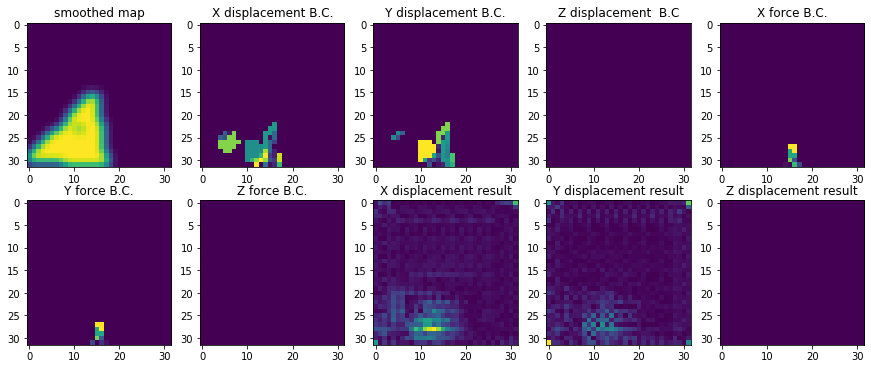

In [61]:
## plot one of the results after passing the convolutional network through it once
sample_prediction = net.cpu().forward(dataset[0][sample:sample+1,:,:,:])
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])

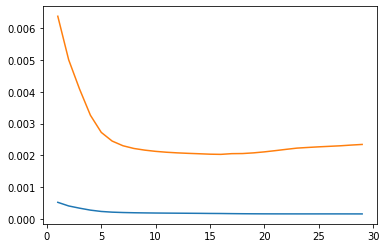

In [62]:
## plot losses over time
plt.plot(losses[2:,0], losses[2:,1:])